# Collaboration and Competition

---

This notebook trains the agent for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
from ddpg_agent import Agent
import torch
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the second agent looks like:', states[1])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.4669857  -1.5
  0.          0.         -6.83172083  6.          0.          0.        ]


### 3. Create Agent

For this project, we are going to use a Deep Deterministic Policy Gradient (DDPG) agent. Below we will initialize this agent.

In [5]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=10)

### 4. Random Agent Baseline

As a baseline, we can watch how a random agent performs in this environment.

In [6]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

### 5. Train DDPG Agent

In this section we will be defining the training loop for our DDPG agent and running it.

C:\Users\Trevor\anaconda3\envs\drlnd_clean\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Average Score: 0.01	Score: 0.00
Episode 200	Average Score: 0.01	Score: 0.10
Episode 300	Average Score: 0.13	Score: 0.30
Episode 367	Average Score: 0.51	Score: 2.60
Environment solved in 367 episodes!	Average Score: 0.51


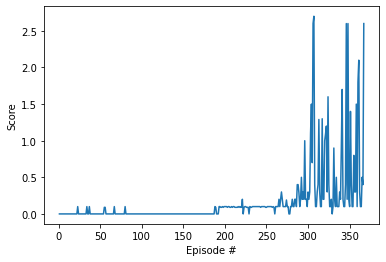

In [7]:
def ddpg(n_episodes=2000, epsilon=1.0, epsilon_decay=0.995, sigma=1):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]       # reset the environment
        agent.reset(epsilon=epsilon, sigma=sigma)               # reset the agent and update epsilon
        epsilon *= epsilon_decay                                # decay epsilon
        state = env_info.vector_observations                    # get the current state
        score = np.zeros(num_agents)
        while True:
            action = []
            for a in range(num_agents):                         # get an action for each agent
                action.append(agent.act(state[a]))
            env_info = env.step(action)[brain_name]             # send the action to the environment
            next_state = env_info.vector_observations           # get the next state
            reward = env_info.rewards                           # get the reward
            done = env_info.local_done                          # see if episode has finished
            agent.step(state, action, reward, next_state, done) # update the environment
            state = next_state
            score += reward
            if any(done):                                       # exit loop if episode finished
                break 
        scores_deque.append(np.max(score))                      # record scores in 100 score buffer
        scores.append(np.max(score))                            # record scores
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), np.max(score)), end="")
        if i_episode % 100 == 0:                                # print the score and save a checkpoint every 100 episodes
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   
        if np.mean(scores_deque)>=0.5:                          # save the final agent and stop when the environment is solved
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
    return scores

# run the ddpg training loop
scores = ddpg()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 6. Watch Final Agent

Now that we've solved the environment. Let's watch our final agent in 1 episode.

In [8]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations               # get the current state
score = np.zeros(num_agents)                       # initialize the score
while True:
    action = []
    for a in range(num_agents):                    # get an action for each agent
        action.append(agent.act(state[a], add_noise=False))
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations      # get the next state
    reward = env_info.rewards                      # get the reward
    done = env_info.local_done                     # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if any(done):                                  # exit loop if episode finished
        break 

print("Score: {}".format(np.mean(score)))

C:\Users\Trevor\anaconda3\envs\drlnd_clean\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Score: 1.095000016503036


When finished, you can close the environment.

In [9]:
env.close()